# 0. Imports

In [1]:
from sampling.conditional_probability_path import GaussianConditionalProbabilityPath
from sampling.sampleable import PixelArtSampler
from sampling.noise_scheduling import LinearAlpha, LinearBeta
from models.unet import PixelArtUNet
from training.trainer import UnguidedTrainer
from training.evaluation import FID
from diff_eq.ode_sde import UnguidedVectorFieldODE
from diff_eq.simulator import EulerSimulator
from utils.visualization import visualize_training_logs

import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Train

In [ ]:
if 'unet' in locals():
    del unet
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

# Initialize probability path
sampler = PixelArtSampler('../dataset/images').to(device)
path = GaussianConditionalProbabilityPath(
    p_data=sampler,
    p_simple_shape = [4, 128, 128],
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

# Initialize model
unet = PixelArtUNet(
    channels = [128, 256, 512],
    num_residual_layers = 2,
    t_embed_dim = 256
)

# Initialize evaluation metric
metric = FID(
    feature=2048,
    normalize=True,
    image_size=(299, 299)
)

# Initialize trainer
trainer = UnguidedTrainer(
    path=path,
    model=unet,
    experiment_dir="experiments/unet",
    eval_metric=metric
)


# Train :D
trainer.train(
    device=device,
    num_epochs=20000,
    batch_size=64,
    lr=1e-4,
    validate_every=500,
    resume=False,
    lr_warmup_steps_frac=0.1,
    num_images_to_save=3,
    save_images_every=500
)

# 2. Visualize model performance over time

In [ ]:
visualize_training_logs(log_path="experiments/unet/training_log.csv", scale="linear")

# 3. Visualize results

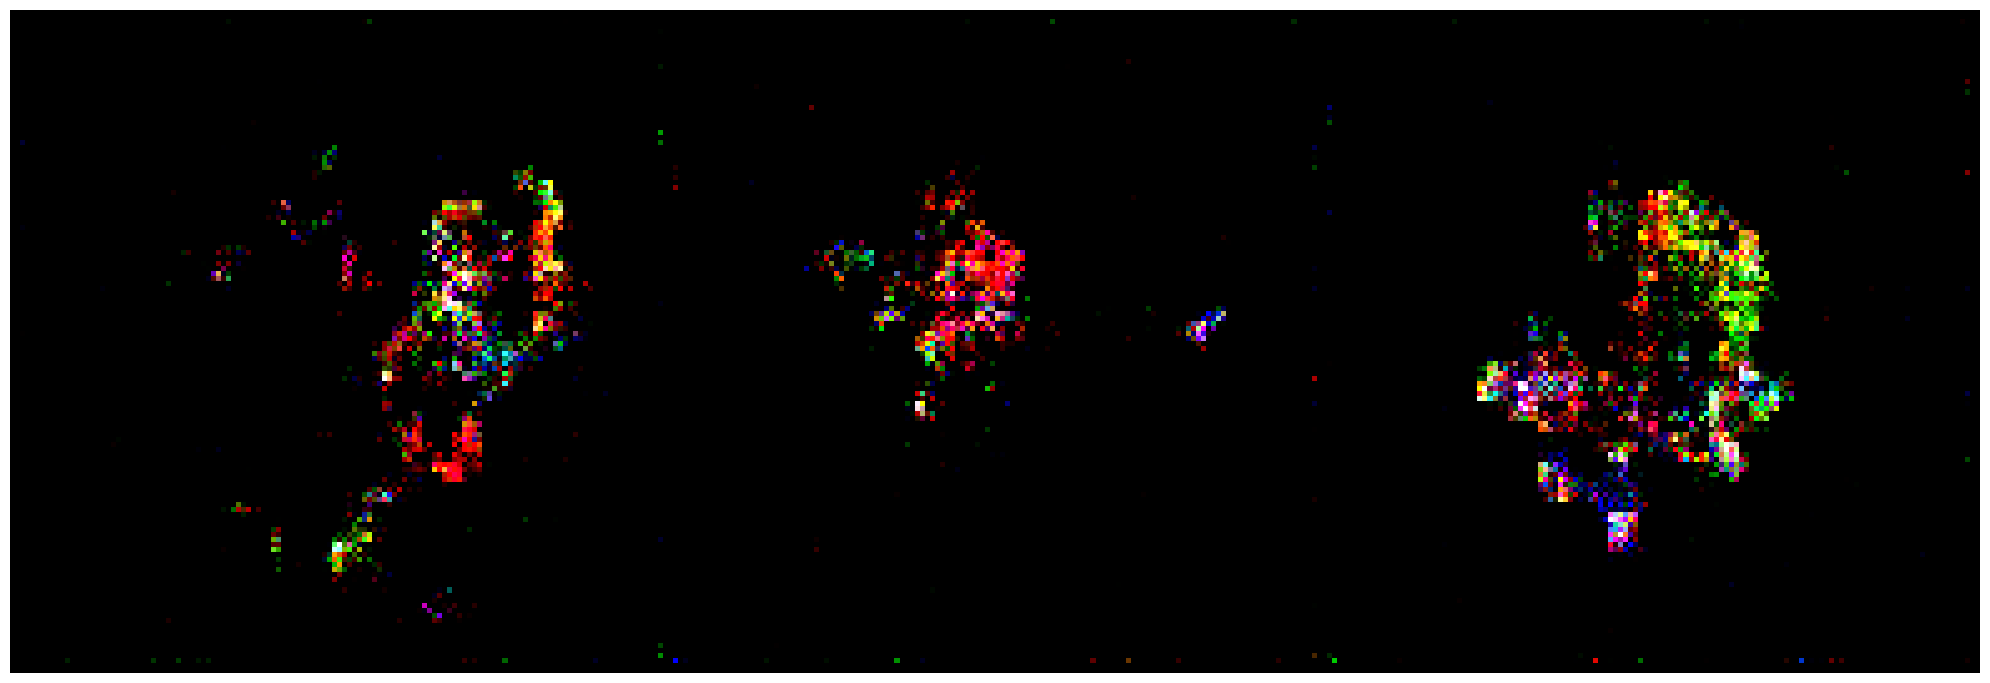

In [12]:
# Parameters
num_samples = 3
num_timesteps = 100

# Load model from checkpoints
cp = torch.load('training/experiments/unet/best_model.pt', map_location=device)
model = PixelArtUNet(
    channels = [128, 256, 512],
    num_residual_layers = 2,
    t_embed_dim = 256
).to(device)
model.load_state_dict(cp["model_state"])
model.eval()

# Load path
sampler = PixelArtSampler('dataset/images').to(device)
path = GaussianConditionalProbabilityPath(
    p_data=sampler,
    p_simple_shape = [4, 128, 128],
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

# Simulate
ts = torch.linspace(0, 1, num_timesteps).view(1, -1, 1, 1, 1).expand(num_samples, -1, 1, 1, 1).to(device)
x0 = path.p_simple.sample(num_samples).to(device)  # (num_samples, 4, 128, 128)

# Run simulation
ode = UnguidedVectorFieldODE(model)
simulator = EulerSimulator(ode)
x1 = simulator.simulate(x0, ts)  # (num_samples, 4, 128, 128)

# Make grid from output (only use first 3 channels if RGB)
img = x1[:, :3]  # (num_samples, 3, H, W)
grid = make_grid(img, nrow=num_samples, normalize=False)

# Plot
plt.figure(figsize=(20, 10))
plt.imshow(grid.permute(1, 2, 0).clamp(0,1).cpu().numpy())
plt.axis("off")
plt.tight_layout()
plt.show()